# Data Manipulation and Figures
## Refer to README.md for discussion

In [1]:
# Dependencies and Setup
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "../../UNCRAL20190514DATA/02-Homework/05-Matplotlib/Instructions/Pymaceuticals/data/mouse_drug_data.csv"
clinical_trial_data_to_load = "../../UNCRAL20190514DATA/02-Homework/05-Matplotlib/Instructions/Pymaceuticals/data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mousedat = pd.read_csv(mouse_drug_data_to_load)
clindat  = pd.read_csv(clinical_trial_data_to_load)

In [2]:
# Check uniqueness
unique_check = mousedat
unique_check["Count"] = 1
sums = unique_check.groupby(["Mouse ID", "Drug"]).sum().groupby("Mouse ID").sum()

# If a mouse shows up in dups, it means they were dosed with more than one drug
problems = sums.loc[sums["Count"] > 1]
dups = problems.merge(mousedat, how="left", on="Mouse ID")["Mouse ID"].tolist()

# This is not a crossover trial, so this mouse must be removed
if len(dups)>0:
    clean_mousedat = mousedat.loc[ ~(mousedat["Mouse ID"].isin(dups)) ]
else:
    clean_mousedat = mousedat

In [3]:
# Combine the data into a single dataset
alldat = clindat.merge(clean_mousedat, on="Mouse ID", how="right")

# Display the data table for preview
alldat.head(5)

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug,Count
0,b128,0,45.000000,0,Capomulin,1
1,b128,5,45.651331,0,Capomulin,1
2,b128,10,43.270852,0,Capomulin,1
3,b128,15,43.784893,0,Capomulin,1
4,b128,20,42.731552,0,Capomulin,1


## Tumor Response to Treatment

In [4]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
mean_d_t = alldat.groupby(["Drug", "Timepoint"]).mean()[["Tumor Volume (mm3)", "Metastatic Sites"]]

# Preview DataFrame
mean_d_t.head(5)


Tumor Volume (mm3)  Metastatic Sites
Drug      Timepoint                                      
Capomulin 0                   45.000000          0.000000
          5                   44.266086          0.160000
          10                  43.084291          0.320000
          15                  42.064317          0.375000
          20                  40.716325          0.652174

In [5]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
sem_d_t = alldat.groupby(["Drug", "Timepoint"]).sem()[["Tumor Volume (mm3)", "Metastatic Sites"]]

# Preview DataFrame
sem_d_t.head(5)

Tumor Volume (mm3)  Metastatic Sites
Drug      Timepoint                                      
Capomulin 0                    0.000000          0.000000
          5                    0.448593          0.074833
          10                   0.702684          0.125433
          15                   0.838617          0.132048
          20                   0.909731          0.161621

In [6]:
# Minor Data Munging to Re-Format the Data Frames
mean_d_t["Tumor Volume (mm3)"] = mean_d_t["Tumor Volume (mm3)"].map("{:,.1f}".format) 
mean_d_t["Metastatic Sites"] = mean_d_t["Metastatic Sites"].map("{:,.1f}".format) 

sem_d_t["Tumor Volume (mm3)"] = sem_d_t["Tumor Volume (mm3)"].map("{:,.2f}".format) 
sem_d_t["Metastatic Sites"] = sem_d_t["Metastatic Sites"].map("{:,.2f}".format) 

# Preview that Reformatting worked
sem_d_t.head()

Tumor Volume (mm3) Metastatic Sites
Drug      Timepoint                                    
Capomulin 0                       0.00             0.00
          5                       0.45             0.07
          10                      0.70             0.13
          15                      0.84             0.13
          20                      0.91             0.16

In [7]:
# Pivot the values
def pivot_df(source, value):
    source = source.reset_index(level=[0, 1])
    return source.pivot(index="Timepoint", columns="Drug", values=value).apply(pd.to_numeric)

# Nothing will graph properly if it isn't numeric
mean_tumor = pivot_df(mean_d_t, "Tumor Volume (mm3)")
mean_metastatic = pivot_df(mean_d_t, "Metastatic Sites")
sem_tumor = pivot_df(sem_d_t, "Tumor Volume (mm3)")
sem_metastatic = pivot_df(sem_d_t, "Metastatic Sites")

sorted_tumor = mean_tumor.iloc[-1].sort_values().index.tolist()
sorted_metastatic = mean_metastatic.iloc[-1].sort_values().index.tolist()

timepoints = mean_tumor.index.tolist()

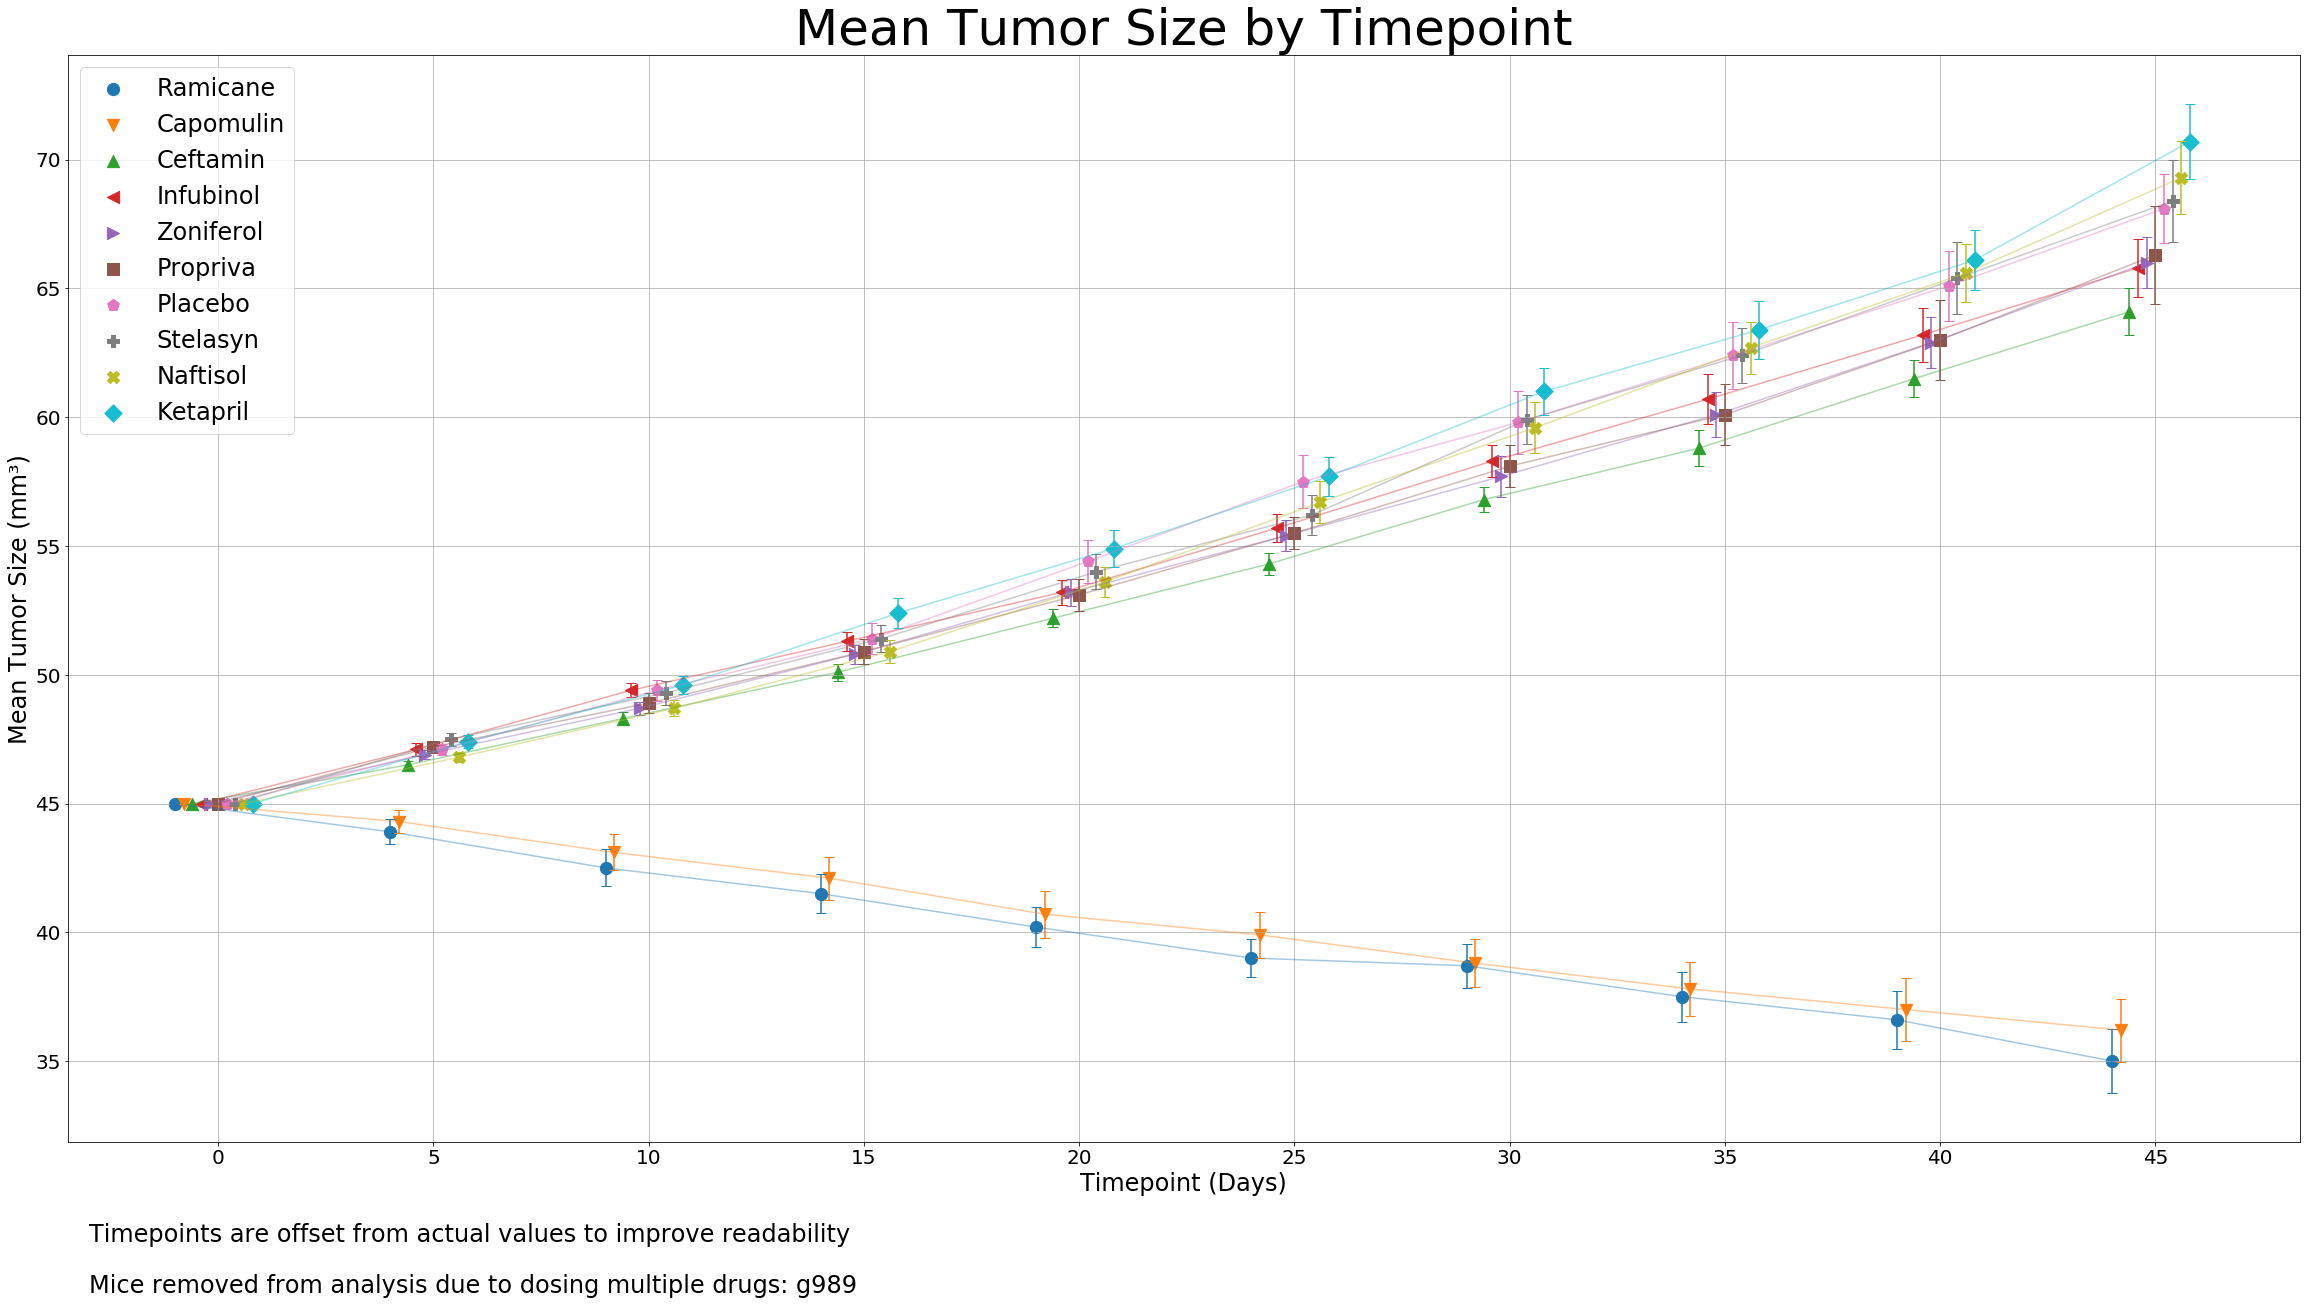

In [8]:
# Generate the Plot (with Error Bars)

# TODO: Hardcode the drug values to this list
# TODO: Always sort the legend alphabetically
# TODO: Except, always put Placebo first or last

# Ensure consistent formatting
formatting = [
    {"color": "C0", "symbol": "o"},
    {"color": "C1", "symbol": "v"},
    {"color": "C2", "symbol": "^"},
    {"color": "C3", "symbol": "<"},
    {"color": "C4", "symbol": ">"},
    {"color": "C5", "symbol": "s"},
    {"color": "C6", "symbol": "p"},
    {"color": "C7", "symbol": "P"},
    {"color": "C8", "symbol": "X"},
    {"color": "C9", "symbol": "D"},
]

# The loop below will generate this
format_dict = {}

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(40)
ax.grid()
ax.set_xticks(timepoints)
ax.set_xlabel("Timepoint (Days)", fontsize=24)
ax.set_ylabel("Mean Tumor Size (mm\u00b3)", fontsize=24)
ax.set_title("Mean Tumor Size by Timepoint", fontsize=50)
ax.tick_params(labelsize=20)

# NOTE: Applying slight offsets to scatter so data do not overlap
for index, drug in enumerate(sorted_tumor):
    format_dict[drug] = formatting[index]
    ax.plot(mean_tumor.index - 1 + 0.2*index, 
            mean_tumor[drug],
            color = formatting[index]["color"],
            alpha = 0.4)
    ax.scatter(mean_tumor.index - 1 + 0.2*index,
               mean_tumor[drug],
               s = 150,
               c = formatting[index]["color"],
               marker = formatting[index]["symbol"],
               label=drug)
    ax.errorbar(mean_tumor.index - 1 + 0.2*index,
                mean_tumor[drug],
                yerr = sem_tumor[drug],
                ecolor = formatting[index]["color"],
                capsize = 5,
                ls = 'none')

ax.legend(fontsize=24)
ax.text(-3, 28, "Timepoints are offset from actual values to improve readability", ha='left', fontsize=24)
if len(dups) > 0:
    ax.text(-3, 26, f"Mice removed from analysis due to dosing multiple drugs: {'; '.join(set(dups))}", ha='left', fontsize=24)
# Need to add another footnote about the removed mouse

# Save the Figure
plt.savefig('mean_tumor.png')
            
# Show the Figure
plt.show()

## Metastatic Response to Treatment

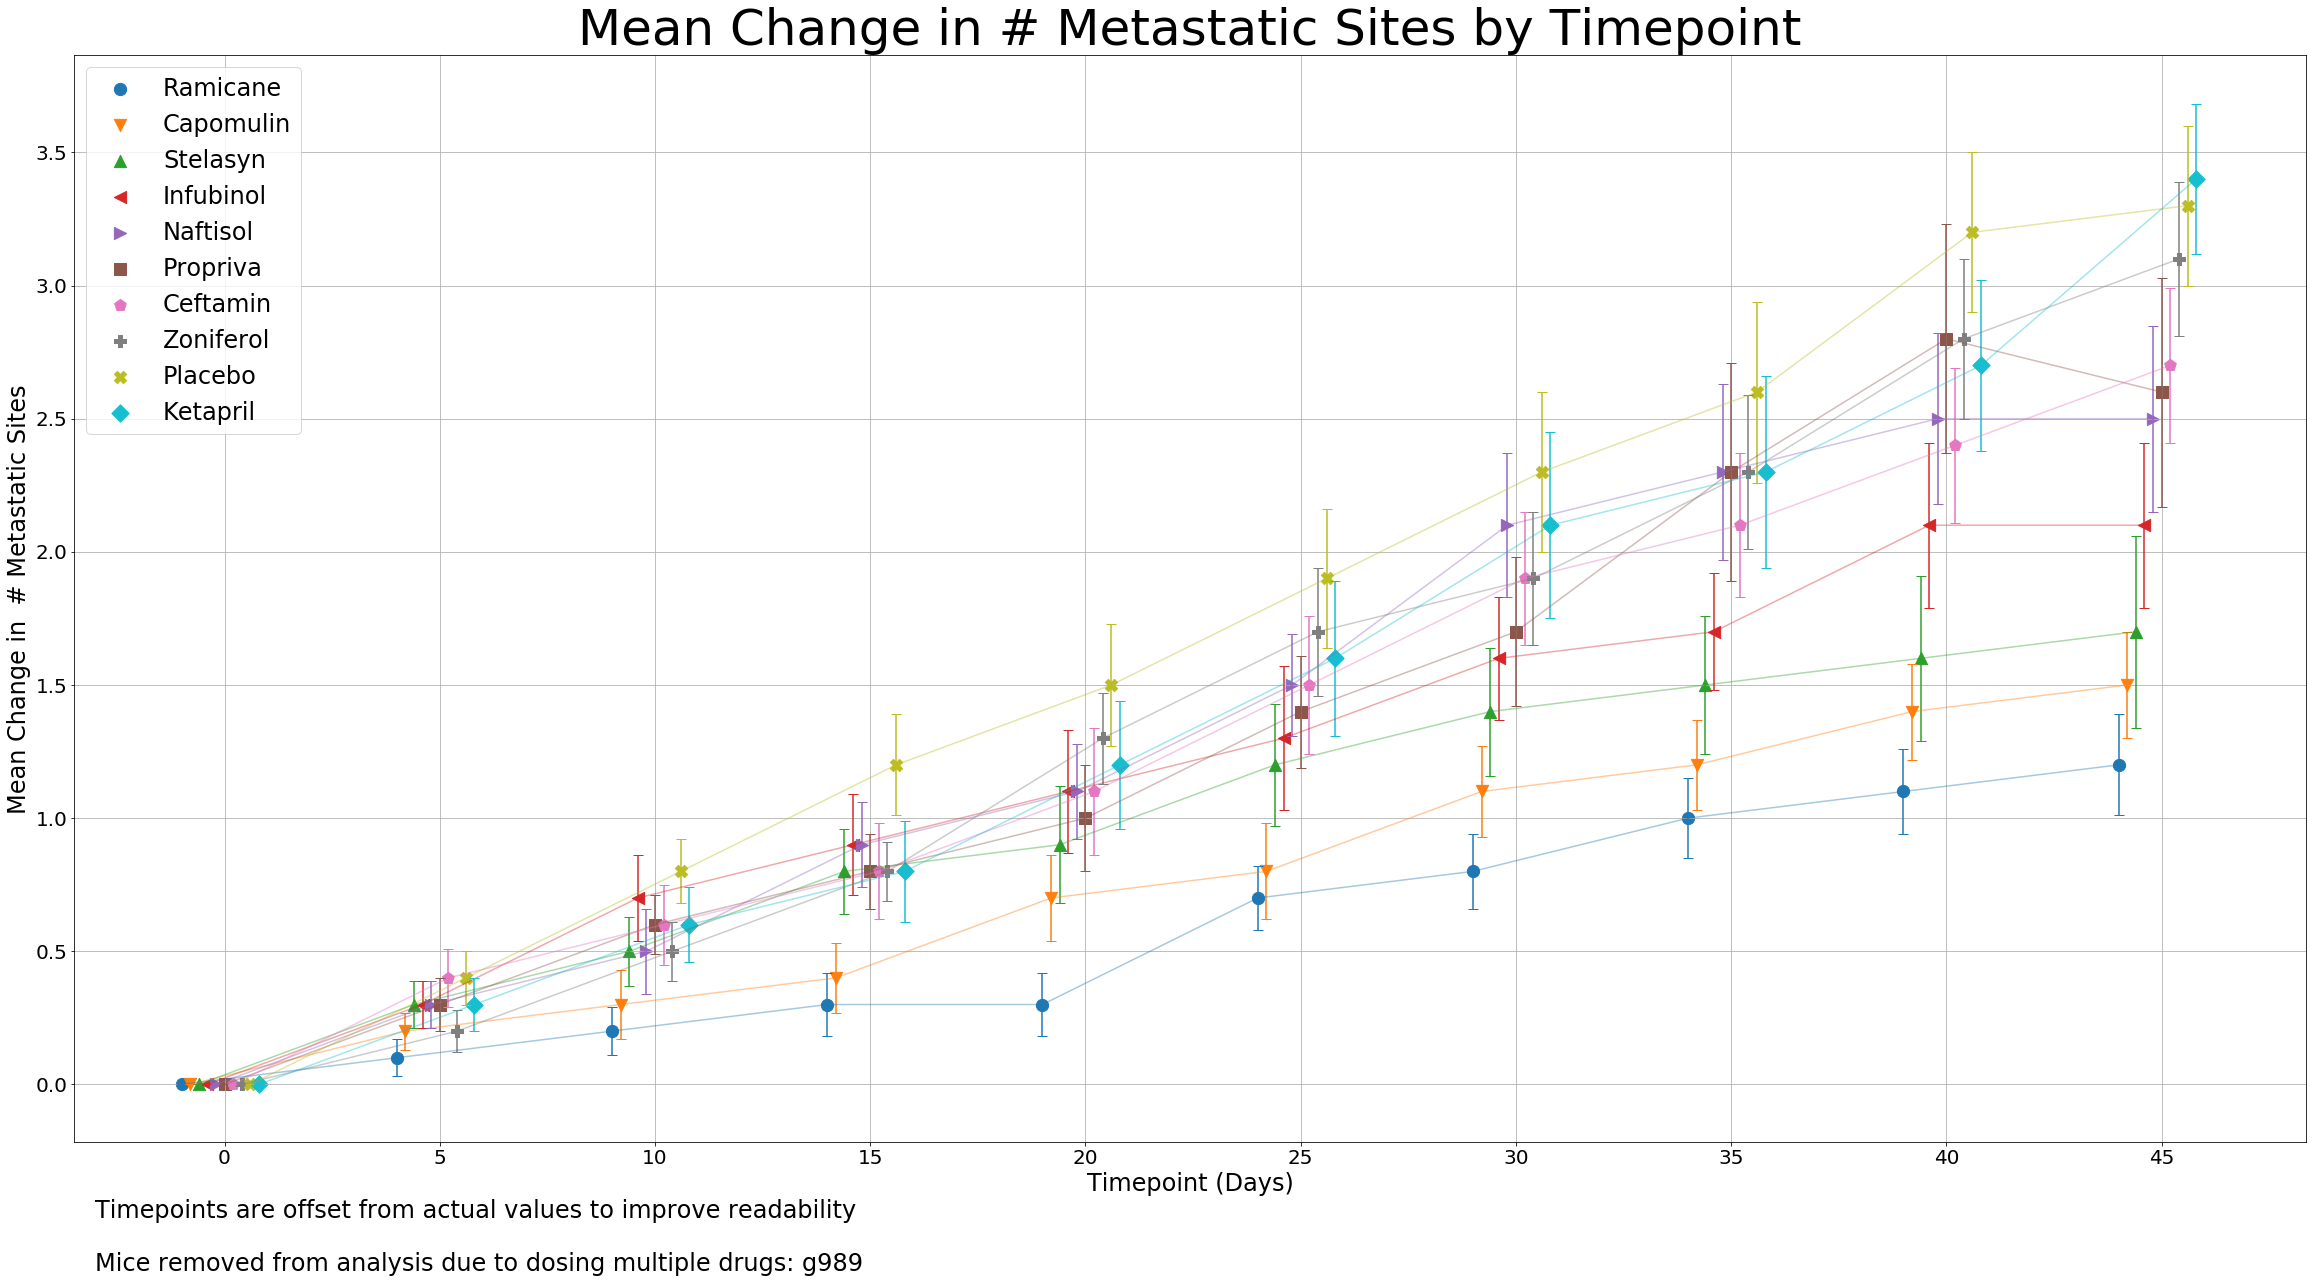

In [9]:
fig, ax = plt.subplots()

fig.set_figheight(20)
fig.set_figwidth(40)
ax.grid()
ax.set_xticks(timepoints)
ax.set_xlabel("Timepoint (Days)", fontsize=24)
ax.set_ylabel("Mean Change in  # Metastatic Sites", fontsize=24)
ax.set_title("Mean Change in # Metastatic Sites by Timepoint", fontsize=50)
ax.tick_params(labelsize=20)

# NOTE: Applying slight offsets to scatter so data do not overlap
for index, drug in enumerate(sorted_metastatic):
    ax.plot(mean_metastatic.index - 1 + 0.2*index, 
            mean_metastatic[drug],
            color = formatting[index]["color"],
            alpha = 0.4)
    ax.scatter(mean_metastatic.index - 1 + 0.2*index,
               mean_metastatic[drug],
               s = 150,
               c = formatting[index]["color"],
               marker = formatting[index]["symbol"],
               label=drug)
    ax.errorbar(mean_metastatic.index - 1 + 0.2*index,
                mean_metastatic[drug],
                yerr = sem_metastatic[drug],
                ecolor = formatting[index]["color"],
                capsize = 5,
                ls = 'none')

ax.legend(fontsize=24)
ax.text(-3, -0.5, "Timepoints are offset from actual values to improve readability", ha='left', fontsize=24)
if len(dups) > 0:
    ax.text(-3, -0.7, f"Mice removed from analysis due to dosing multiple drugs: {'; '.join(set(dups))}", ha='left', fontsize=24)
# Need to add another footnote about the removed mouse

# Save the Figure
plt.savefig('mean_metastatic.png')
            
# Show the Figure            
plt.show()

## Survival Rates

In [10]:
# Get mouse counts per drug and timepoint
survival = alldat[['Mouse ID', 'Drug', 'Timepoint']].groupby(["Mouse ID", "Drug"]).max().reset_index()

for timepoint in timepoints:
    survival[f"T{timepoint}"] = survival["Timepoint"] >= timepoint
    
survival_summary = survival.groupby("Drug").sum()

# From counts, derive survival rates
for timepoint in timepoints:
    survival_summary[f"P{timepoint}"] = 100 * (survival_summary[f"T{timepoint}"] / survival_summary["T0"])
    
survival_summary[["P0", "P5", "P10", "P15", "P20", "P25", "P30", "P35", "P40", "P45"]]

,P0,P5,P10,P15,P20,P25,P30,P35,P40,P45
Drug,,,,,,,,,,
Capomulin,100.0,100.000000,100.0,96.0,92.000000,88.000000,88.000000,88.0,84.0,84.000000
Ceftamin,100.0,84.000000,80.0,76.0,72.000000,72.000000,64.000000,56.0,56.0,52.000000
Infubinol,100.0,100.000000,84.0,84.0,80.000000,72.000000,68.000000,48.0,40.0,36.000000
Ketapril,100.0,92.000000,88.0,76.0,76.000000,76.000000,72.000000,68.0,60.0,44.000000
Naftisol,100.0,92.000000,84.0,84.0,80.000000,72.000000,60.000000,60.0,60.0,52.000000
Placebo,100.0,96.000000,96.0,80.0,76.000000,68.000000,60.000000,56.0,48.0,44.000000
Propriva,100.0,95.833333,87.5,62.5,62.500000,54.166667,50.000000,37.5,37.5,29.166667
Ramicane,100.0,100.000000,96.0,96.0,92.000000,92.000000,92.000000,84.0,80.0,80.000000
Stelasyn,100.0,95.833333,87.5,87.5,79.166667,75.000000,70.833333,62.5,50.0,45.833333


In [11]:
# Match layout above to reuse code

# First, make long
survival_summary_ = survival_summary.reset_index()
survival_long = pd.wide_to_long(df=survival_summary_[["Drug", "P0", "P5", "P10", "P15", "P20", "P25", "P30", "P35", "P40", "P45"]],
                                stubnames="P", i="Drug", j="Timepoint").sort_index()

# Then pivot
survival_pivot = pivot_df(survival_long, "P").apply(pd.to_numeric)

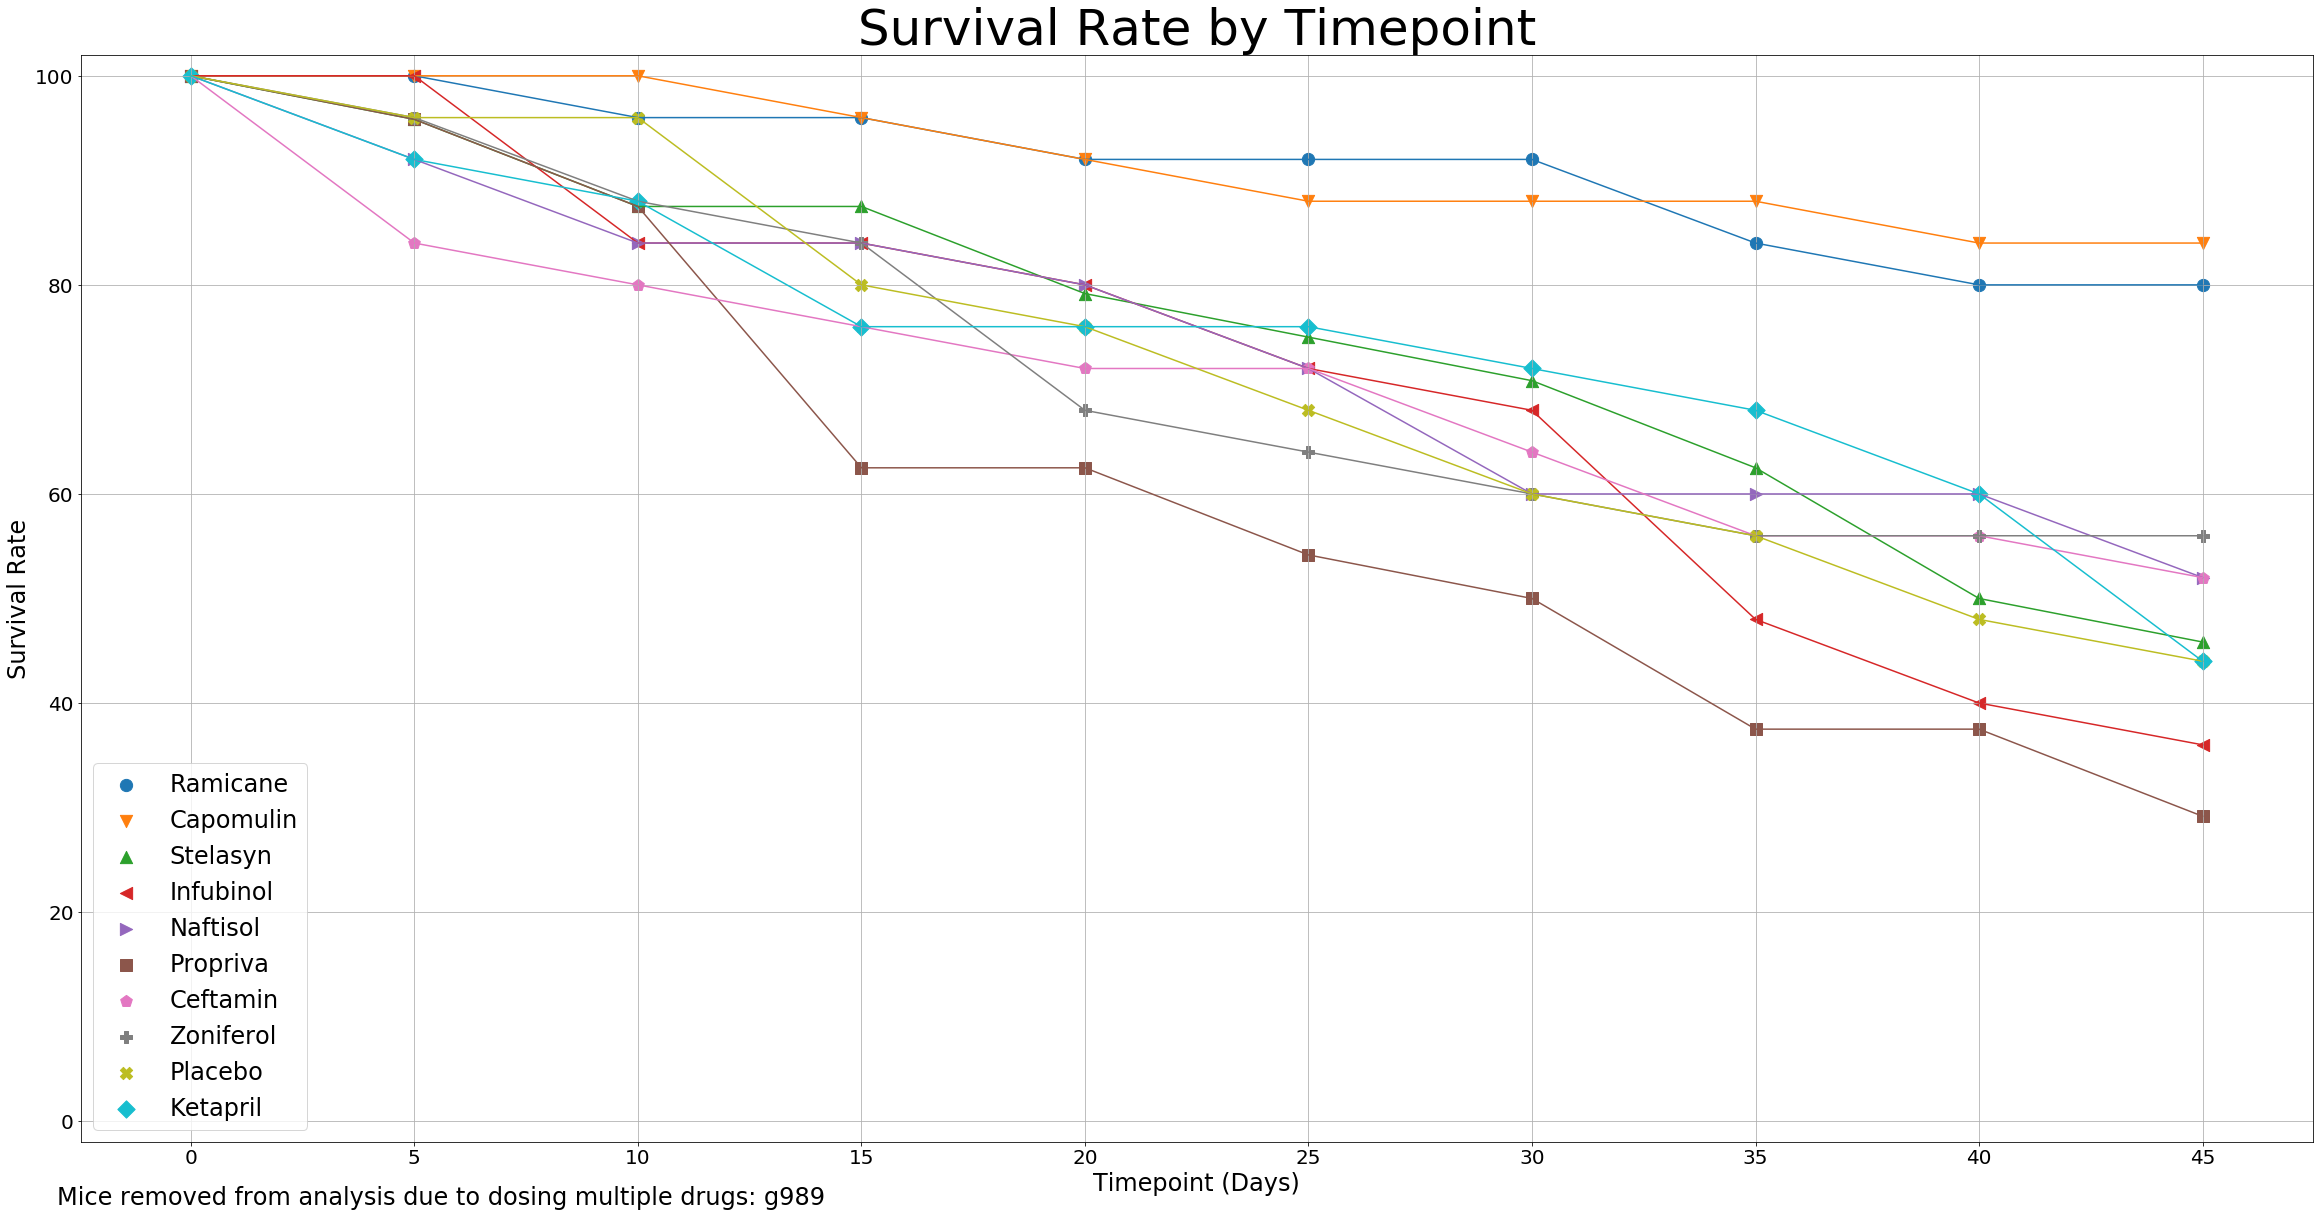

In [12]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(40)
ax.grid()
ax.set_xticks(timepoints)
ax.set_xlabel("Timepoint (Days)", fontsize=24)
ax.set_ylabel("Survival Rate", fontsize=24)
ax.set_ylim((-2, 102))
ax.set_title("Survival Rate by Timepoint", fontsize=50)
ax.tick_params(labelsize=20)

# NOTE: Applying slight offsets to scatter so data do not overlap
for index, drug in enumerate(sorted_metastatic):
    ax.plot(survival_pivot.index, 
            survival_pivot[drug],
            color = formatting[index]["color"])
    ax.scatter(survival_pivot.index,
               survival_pivot[drug],
               s = 150,
               c = formatting[index]["color"],
               marker = formatting[index]["symbol"],
               label=drug)

ax.legend(fontsize=24)
#ax.text(-3, -8, "Timepoints are offset from actual values to improve readability", ha='left', fontsize=24)
if len(dups) > 0:
    ax.text(-3, -8, f"Mice removed from analysis due to dosing multiple drugs: {'; '.join(set(dups))}", ha='left', fontsize=24)

# Save the Figure
plt.savefig('survival.png')
            
# Show the Figure
plt.show()

## Summary Bar Graph

In [13]:
# Reverse rows and columns in existing pivot table to derive percent change
mtt = mean_tumor.transpose().reset_index()
mtt["Percent Change From Baseline"] = ((mtt[45] - mtt[0]) / mtt[0]) * 100
mtt = mtt.sort_values("Percent Change From Baseline")

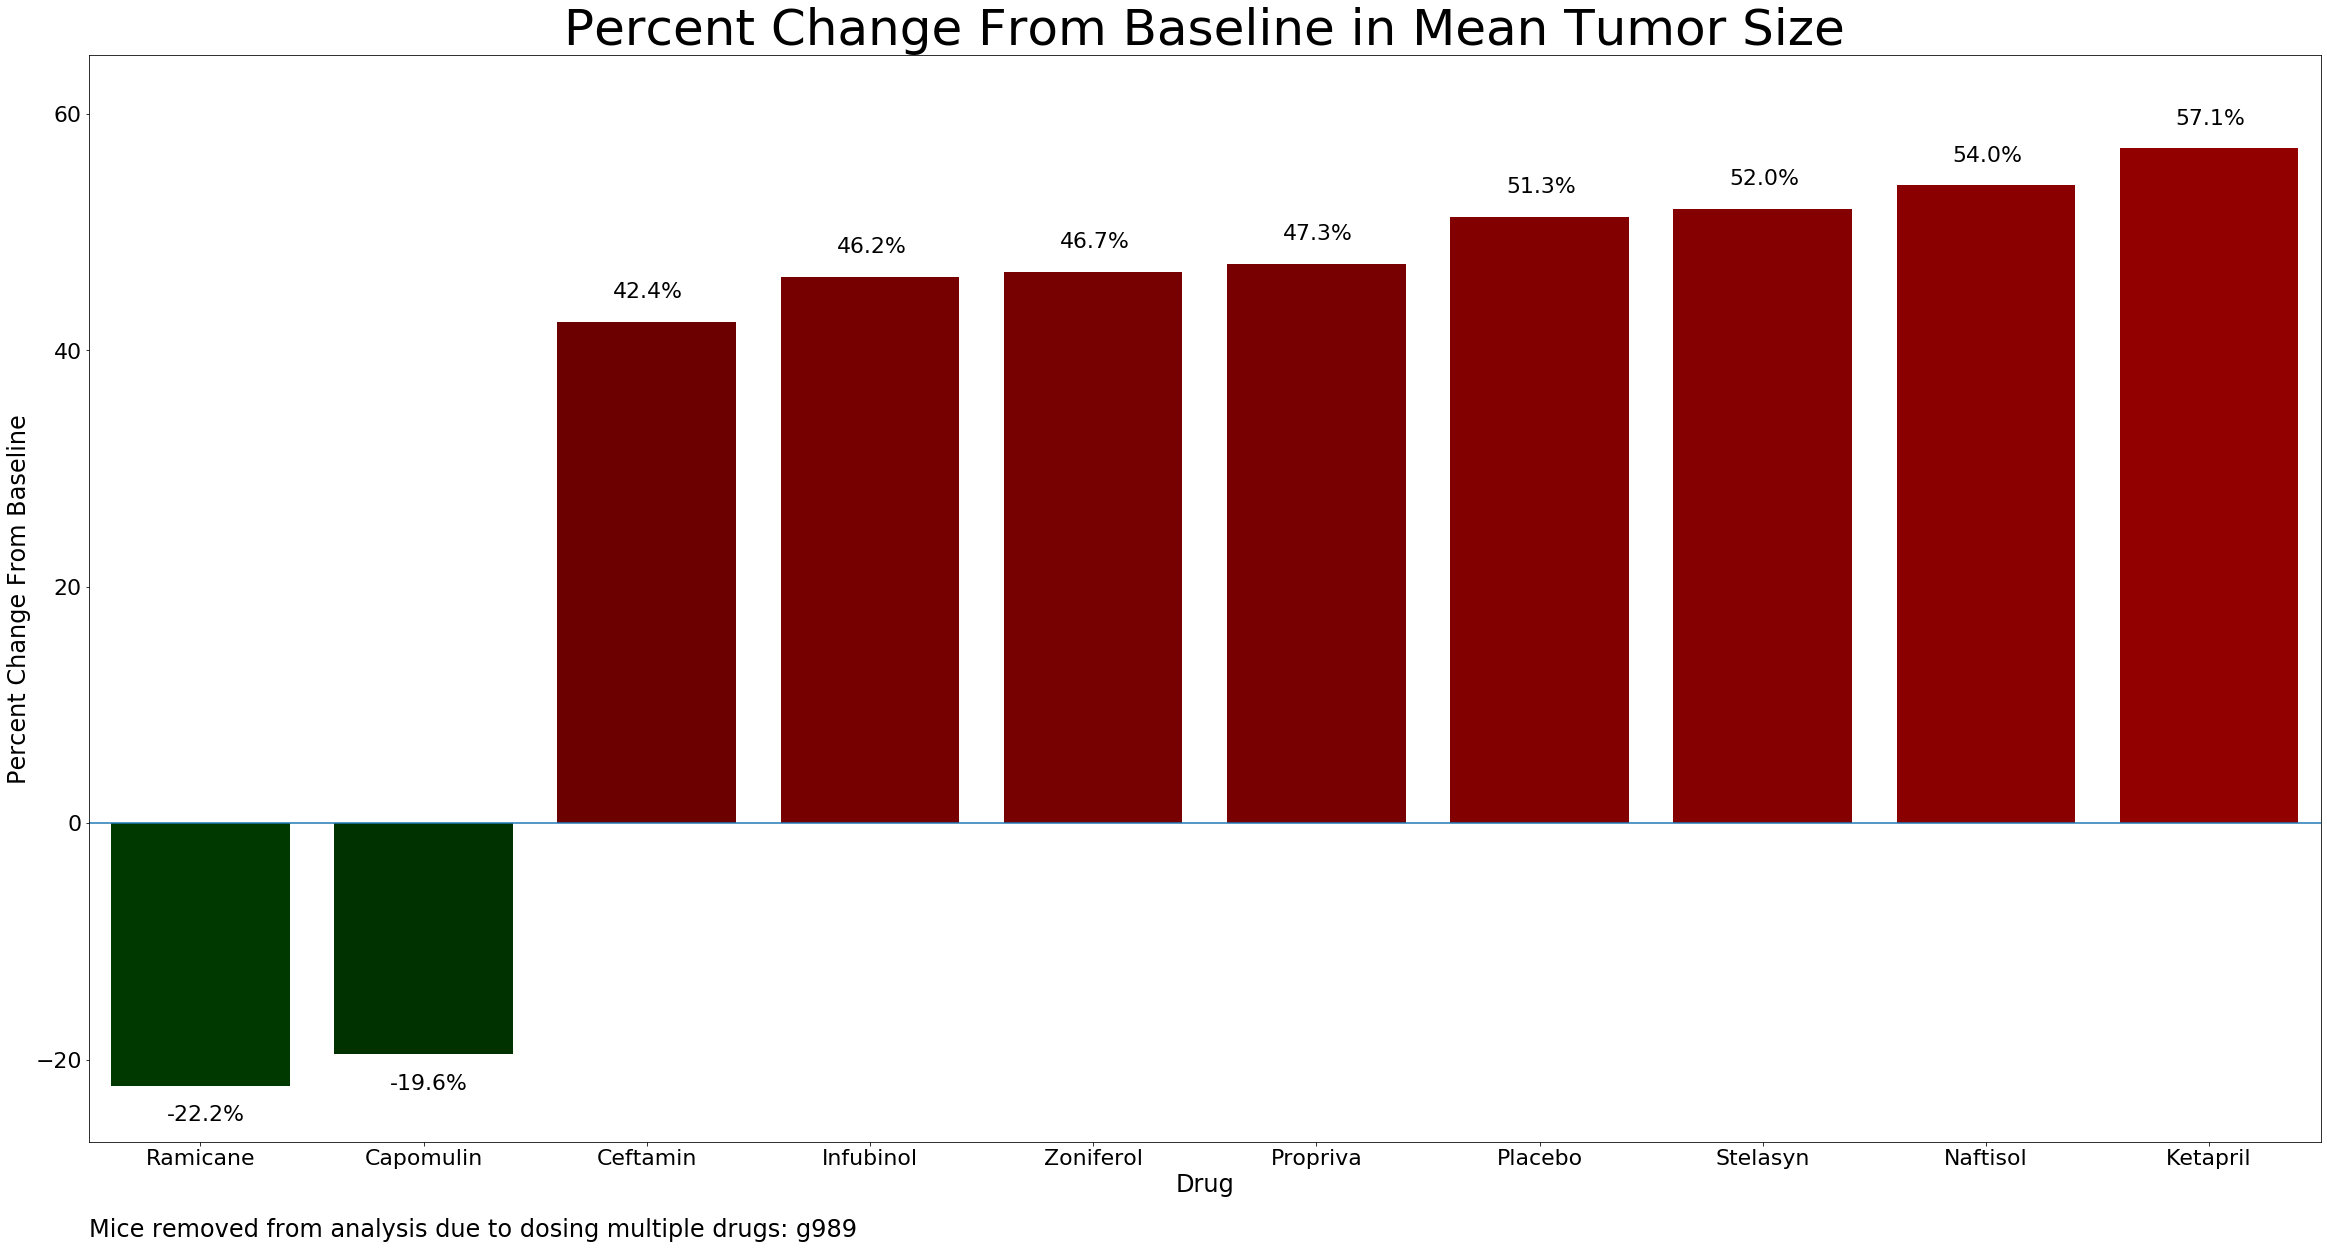

In [14]:
# Apply color gradient
def get_color(val):
    if -100 < val < 0:
        return (0, abs(val/100), 0)
    elif val <= -100:
        return (0, 1, 0)
    elif 0 <= val < 100:
        return (val/100, 0, 0)
    else:
        return (1, 0, 0)
    
color_list1 = [get_color(value) for value in mtt["Percent Change From Baseline"]]

# The color scheme used above
color_list2 = [format_dict[value]["color"] for value in mtt["Drug"]]

# Above code works, but probably better to keep the established color scheme
plt.rcParams.update({"font.size": 22})
plt.figure(figsize=(40, 20))
plt.bar(mtt["Drug"], mtt["Percent Change From Baseline"], color=color_list1)
plt.xlabel("Drug", fontsize=24)
plt.ylabel("Percent Change From Baseline", fontsize=24)
plt.title("Percent Change From Baseline in Mean Tumor Size", fontsize=50)
plt.plot([-20, 20], [0, 0])
plt.xlim([-0.5, 9.5])
plt.ylim([-27, 65])

for index, drug in enumerate(mtt["Drug"]):
    pct = mtt.loc[mtt["Drug"] == drug]["Percent Change From Baseline"].values[0]
    xpos = index - 0.15
    ypos = -1*(pct < 0)*5 + pct + 2
    text = f"{pct/100:.1%}"
    
    plt.text(xpos, ypos, text)
    
if len(dups) > 0:
    plt.text(-0.5, -35, f"Mice removed from analysis due to dosing multiple drugs: {'; '.join(set(dups))}", ha='left', fontsize=24)

plt.savefig("pchg.png")             
    
plt.show()